In [42]:
import sys
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 

sys.path.append('../../src/thermal/')

from open import dataset as open_dataset
import plotting as plotting

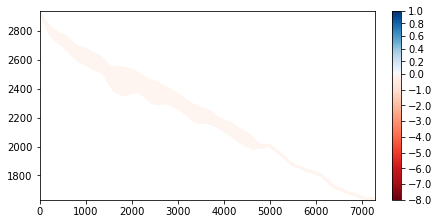

In [43]:
with open_dataset('result/glc1-a/nc/glc1-a_dx_50_MB_-1.5_OFF_Tma_-7.0_diag_44intpoints.nc') as src: 
    fig, ax, cb = plotting.enthalpy_pcolormesh(src, -1, W_max=1);
        
    # ax.set_title(file)

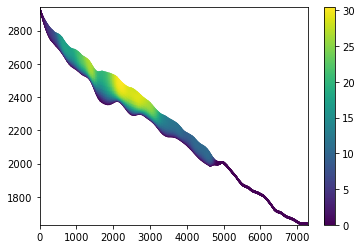

In [44]:
plt.pcolormesh(src.X[:,::-1], 
               src.Z.isel(t=-1), 
               src['vel_m'].isel(t=-1), 
               shading='gouraud')
plt.colorbar()

In [41]:
spy = 365.25*24.0*3600.0

print(f'{2.89165e-13*spy*1.0e18:e}')
print(f'{ 2.42736e-02*spy*1.0e18:e}')

9.125353e+12
7.660166e+23


In [38]:
print(f'{3.985e-13*spy*1.0e18:e}')
print(f'{1.916e3*spy*1.0e18:e}')

1.257570e+13
6.046436e+28
